In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import precision_score, recall_score, average_precision_score, make_scorer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

import re
import string

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("venky73/spam-mails-dataset")

print("Path to dataset files:", path)
print(os.listdir(path))

Using Colab cache for faster access to the 'spam-mails-dataset' dataset.
Path to dataset files: /kaggle/input/spam-mails-dataset
['spam_ham_dataset.csv']


### load dataset

In [3]:
df = pd.read_csv(path + '/spam_ham_dataset.csv')
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [5]:
df.isna().sum()

,0
Unnamed: 0,0
label,0
text,0
label_num,0


In [6]:
df = df.drop(['Unnamed: 0', 'label'], axis=1)
df.head()

,text,label_num
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


In [7]:
df['text_len'] = df['text'].apply(lambda x: len(x.split(' ')))
df.head()

,text,label_num,text_len
0,Subject: enron methanol ; meter # : 988291\r\n...,0,62
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,21
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,541
3,"Subject: photoshop , windows , office . cheap ...",1,39
4,Subject: re : indian springs\r\nthis deal is t...,0,66


### EDA

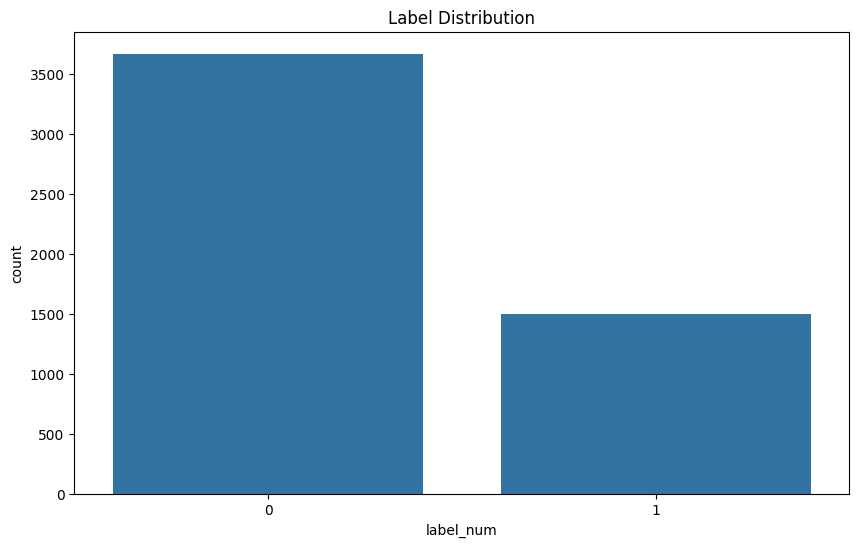

,count
label_num,
0,3672
1,1499


In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label_num', data=df)
plt.title('Label Distribution')
plt.show()

df.label_num.value_counts()

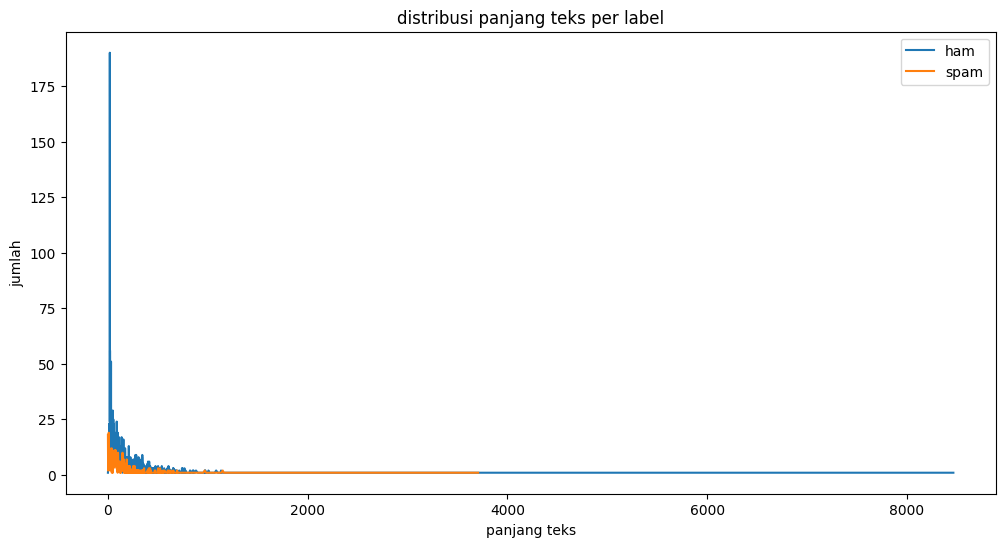

In [9]:
ham_df = df[df['label_num'] == 0]['text_len'].value_counts().sort_index()
spam_df = df[df['label_num'] == 1]['text_len'].value_counts().sort_index()


plt.figure(figsize=(12,6))
plt.plot(ham_df.index, ham_df.values, label='ham')
plt.plot(spam_df.index, spam_df.values, label='spam')
plt.title('distribusi panjang teks per label')
plt.xlabel('panjang teks')
plt.ylabel('jumlah')
plt.legend()
plt.show()

### preprocessing

In [10]:
def clean_text_1(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\r', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def clean_text_2(text):
  text = text.lower()
  text = re.sub(f"[{string.punctuation}]", "", text)
  return text

In [11]:
df['clean_text_1'] = df['text'].apply(lambda x: clean_text_1(x))
df['clean_text_2'] = df['text'].apply(lambda x: clean_text_2(x))
df.head()

,text,label_num,text_len,clean_text_1,clean_text_2
0,Subject: enron methanol ; meter # : 988291\r\n...,0,62,subject enron methanol meter is a follow u...,subject enron methanol meter 988291\r\nthis...
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,21,subject hpl nom for january see attached fi...,subject hpl nom for january 9 2001\r\n see at...
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,541,subject neon retreatho ho ho we re around to...,subject neon retreat\r\nho ho ho we re aroun...
3,"Subject: photoshop , windows , office . cheap ...",1,39,subject photoshop windows office cheap mai...,subject photoshop windows office cheap mai...
4,Subject: re : indian springs\r\nthis deal is t...,0,66,subject re indian springsthis deal is to book...,subject re indian springs\r\nthis deal is to ...


### Modelling

##### clean text 1

In [12]:
X = df['clean_text_1']
y = df['label_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y)

In [13]:
vectorizer = CountVectorizer()

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [14]:
gauss = Pipeline([
    ('vectorizer', CountVectorizer(min_df=2)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ('classifier', GaussianNB())
])

multi = Pipeline([
    ('vectorizer', CountVectorizer(min_df=2)),
    ('classifier', MultinomialNB(alpha=1.0))
])

bernoulli = Pipeline([
    ('vectorizer', CountVectorizer(binary=True, min_df=2)),
    ('classifier', BernoulliNB(alpha=1.0))
])

In [15]:
scoring = {
    'precision_spam': make_scorer(precision_score, pos_label=1),
    'recall_spam': make_scorer(recall_score, pos_label=1),
    'pr_auc': 'average_precision'
}

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42)

results = {}

for name, model in zip(
    ['gauss', 'multi', 'bernoulli'],
    [gauss, multi, bernoulli]
):
    cv_results = cross_validate(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring
    )

    results[(name, 'Score')] = {
        'Precision': cv_results['test_precision_spam'].mean(),
        'Recall': cv_results['test_recall_spam'].mean(),
        'PR AUC': cv_results['test_pr_auc'].mean()
    }

    results[(name, 'Mean ± Std')] = {
        'Precision': f"{cv_results['test_precision_spam'].mean():.4f} ± {cv_results['test_precision_spam'].std():.4f}",
        'Recall': f"{cv_results['test_recall_spam'].mean():.4f} ± {cv_results['test_recall_spam'].std():.4f}",
        'PR AUC': f"{cv_results['test_pr_auc'].mean():.4f} ± {cv_results['test_pr_auc'].std():.4f}"
    }

In [16]:
results_df = pd.DataFrame(results).T
print("gauss vs multinomial vs bernoulli (cleaning agresip)")
print(f"\n{results_df}")

gauss vs multinomial vs bernoulli (cleaning agresip)

                            Precision           Recall           PR AUC
gauss     Score              0.962492         0.855725         0.865499
          Mean ± Std  0.9625 ± 0.0078  0.8557 ± 0.0204  0.8655 ± 0.0167
multi     Score              0.937848         0.952472         0.954953
          Mean ± Std  0.9378 ± 0.0139  0.9525 ± 0.0128  0.9550 ± 0.0113
bernoulli Score              0.891142         0.641377         0.898885
          Mean ± Std  0.8911 ± 0.0180  0.6414 ± 0.0160  0.8989 ± 0.0186


##### clean text 2

In [17]:
X2 = df['clean_text_2']
y = df['label_num']

X_train2, X_test2, y_train, y_test = train_test_split(
    X2, y,
    test_size=0.2,
    random_state=42,
    stratify=y)

In [18]:
vectorizer2 = CountVectorizer()

X_train_vec2 = vectorizer2.fit_transform(X_train2)
X_test_vec2 = vectorizer2.transform(X_test2)

In [19]:
gauss = Pipeline([
    ('vectorizer2', CountVectorizer(min_df=2)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ('classifier', GaussianNB())
])

multi = Pipeline([
    ('vectorizer2', CountVectorizer(min_df=2)),
    ('classifier', MultinomialNB(alpha=1.0))
])

bernoulli = Pipeline([
    ('vectorizer2', CountVectorizer(binary=True, min_df=2)),
    ('classifier', BernoulliNB(alpha=1.0))
])

In [20]:
scoring = {
    'precision_spam': make_scorer(precision_score, pos_label=1),
    'recall_spam': make_scorer(recall_score, pos_label=1),
    'pr_auc': 'average_precision'
}

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42)

results_2 = {}

for name, model in zip(
    ['gauss', 'multi', 'bernoulli'],
    [gauss, multi, bernoulli]
):
    cv_results = cross_validate(
        model,
        X_train2,
        y_train,
        cv=cv,
        scoring=scoring
    )

    results_2[(name, 'Score')] = {
        'Precision': cv_results['test_precision_spam'].mean(),
        'Recall': cv_results['test_recall_spam'].mean(),
        'PR AUC': cv_results['test_pr_auc'].mean()
    }

    results_2[(name, 'Mean ± Std')] = {
        'Precision': f"{cv_results['test_precision_spam'].mean():.4f} ± {cv_results['test_precision_spam'].std():.4f}",
        'Recall': f"{cv_results['test_recall_spam'].mean():.4f} ± {cv_results['test_recall_spam'].std():.4f}",
        'PR AUC': f"{cv_results['test_pr_auc'].mean():.4f} ± {cv_results['test_pr_auc'].std():.4f}"
    }

In [21]:
results2_df = pd.DataFrame(results_2).T
print("gauss vs multinomial vs bernoulli (cleaning minimal)")
print(f"\n{results2_df}")

gauss vs multinomial vs bernoulli (cleaning minimal)

                            Precision           Recall           PR AUC
gauss     Score              0.964142         0.873215         0.878677
          Mean ± Std  0.9641 ± 0.0091  0.8732 ± 0.0115  0.8787 ± 0.0124
multi     Score              0.929658         0.967479         0.946583
          Mean ± Std  0.9297 ± 0.0125  0.9675 ± 0.0048  0.9466 ± 0.0081
bernoulli Score              0.893836         0.696433         0.907887
          Mean ± Std  0.8938 ± 0.0142  0.6964 ± 0.0277  0.9079 ± 0.0145
